# VAE를 이용한 생성 모델
- Variational Autoencoder은 오코인코더를 개선하여 평균과 표준편차 두개의 성분을 나타내는 두개의 임베딩 벡터를 생성하게 한다
- 이를 이용하면 생성 모델을 확률적으로 조절하기가 수월해진다

<img src="https://github.com/StillWork/image/blob/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202022-11-23%20%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE%204.06.41.png?raw=1" width =600>

- 새로운 분자의 구조를 생성하는 모델에 적용할 수 있다
- 분자 표현으로 SMILES를 사용하며 새로운 SMILES를 얻는다
 - MolrculeNet이 제공하는 SMILES 데이터셋 MUV 사용 (약 90000개 제공)
 - Maximum Unbiased Validation(MUV) - 17개의 태스크 포함
- [VAE 소개](https://towardsdatascience.com/an-introduction-to-variational-auto-encoders-vaes-803ddfb623df)

# import

In [15]:
# 셀 실행 후 세션 재시작 필요
!pip install deepchem
!pip install flatbuffers==1.12 gast==0.4.0 google-auth-oauthlib==0.4.6 keras==2.9.0 keras-preprocessing==1.1.2 protobuf==3.19.6 tensorboard==2.9.1 tensorboard-data-server==0.6.1 tensorboard-plugin-wit==1.8.1 tensorflow==2.9.0 tensorflow-estimator==2.9.0 --no-deps

ERROR: Could not find a version that satisfies the requirement tensorflow==2.9.0 (from versions: 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0)
ERROR: No matching distribution found for tensorflow==2.9.0


In [1]:
import deepchem as dc
import tensorflow as tf
import tensorflow.keras.layers as layers

import pandas as pd
import numpy as np
import pickle
from rdkit import RDLogger
import warnings

# 모든 경고 무시
warnings.filterwarnings("ignore")

RDLogger.DisableLog('rdApp.*')
%config InlineBackend.figure_format = 'retina'

Skipped loading some Pytorch utilities, missing a dependency. No module named 'torch'


This module requires PyTorch to be installed.


No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
Skipped loading some PyTorch models, missing a dependency. No module named 'torch'
No module named 'torch'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch'
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'torch'
Skipped loading some Jax models, missing a dependency. No module named 'haiku'


# 학습 데이터

In [2]:
tasks, datasets, transformers = dc.molnet.load_muv()
train_dataset, valid_dataset, test_dataset = datasets
train_smiles = train_dataset.ids

print(train_smiles[:10])
print(type(train_smiles))
print(len(train_smiles))

['NC(=O)NC(Cc1ccccc1)C(=O)O' 'Nc1ccc(C(=O)O)c(O)c1'
 'C=CCNC(=S)Nc1ccc(Br)cc1F' 'COC(=O)C(NC(=O)Nc1ccccc1F)C(C)C'
 'CC(C)CC(=O)Nc1ccc(OCC(=O)O)cc1' 'CC(NC(=O)c1ccccc1F)C(=O)O'
 'CCOc1ccc(OCCCN(C)C)cc1' 'CCOc1ccc(OCCCCN(C)C)cc1'
 'CCOC(=O)NC(NC(=O)OCC)C(=O)c1ccccc1'
 'CCOC(=O)C(C(=O)OCC)C(=O)c1cc(OC)c(OC)c(OC)c1']
<class 'numpy.ndarray'>
74469


In [4]:
# coconut database 다운로드 후 파일 압축 해제 및 파일명 확인
! wget https://coconut.s3.uni-jena.de/prod/downloads/2024-09/coconut-09-2024.csv.zip
!unzip ./coconut-09-2024.csv.zip

zsh:1: command not found: wget
Archive:  ./coconut-09-2024.csv.zip
replace coconut-09-2024.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [3]:
coconut = pd.read_csv('./coconut-09-2024.csv')
coconut

,standard_inchi,standard_inchi_key,canonical_smiles,identifier
0,InChI=1S/C43H53N9O14S2.Na/c1-5-22(3)35-36(57)4...,DRKUXFLLRIKRHH-QDVYGYDXSA-M,CC[C@@H]1NC(=O)[C@@H](NC(=O)[C@H](C)NC(=O)CNC(...,CNP0437004.1
1,InChI=1S/C21H32O12/c1-9-14(23)16(25)18(27)21(3...,OXHVQSRYUNGYOK-NUASCYGXSA-N,COC1=CC=C(CCO[C@@H]2O[C@H](CO[C@@H]3O[C@@H](C)...,CNP0243002.1
2,InChI=1S/C36H61N5O7/c1-21(2)18-27-35(47)48-28(...,NEGZFRNAAJQQEG-NOFCQABOSA-N,C/C1=C\[C@@H](C(C)(C)C)OC(=O)[C@H](CC(C)C)N(C)...,CNP0458114.1
3,InChI=1S/C22H22O9/c1-28-12-4-2-11(3-5-12)15-9-...,DQIVYFNWBDHNFD-WHCFWRGISA-N,COC1=CC=C(C2=CC(=O)OC3=CC(O[C@@H]4O[C@H](CO)[C...,CNP0252086.2
4,InChI=1S/C32H41N5O4/c1-6-18(4)28-32(41)36-12-8...,HKVSEIVDIONNKB-QWNGKRCASA-N,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)N1C(=O)[C...,CNP0107934.1
...,...,...,...,...
695128,InChI=1S/C19H19N3O4/c1-26-13-8-6-12(7-9-13)20-...,HHSNDFVMRMIDBG-INIZCTEOSA-N,COC1=CC=C(NC(=O)CC[C@@H]2NC(=O)C3=CC=CC=C3NC2=...,CNP0395779.1
695129,InChI=1S/C30H30N2O10/c1-12-23(34)27(38)28(39)3...,VVPODVCQSZKNKL-RLOKSPFPSA-N,CC(=O)OC1=CC=C2C(=O)C3=C(O)C(CC4=CC=CC(C(N)N)=...,CNP0097600.1
695130,InChI=1S/C21H22O7/c1-11(2)4-5-13-15(23)7-6-14(...,LMFCHRAKSGPODM-OAQYLSRUSA-N,COC1=C([C@]2(O)COC3=CC(O)=CC(O)=C3C2=O)C=CC(O)...,CNP0212403.1
695131,InChI=1S/C20H30O7/c1-17(2)4-3-12(23)18-8-27-20...,IJWNAKYUVUUYTE-HMBONYETSA-N,CC1(C)CC[C@H](O)[C@]23COC(O)([C@@H](O)[C@H]12)...,CNP0494455.1


In [4]:
# SMILES와 cid를 저장할 리스트 생성
coconut_smiles = list(coconut['canonical_smiles'])
coconut_cid = list(coconut['identifier'])

print('cid_names :\t', coconut_cid[:3])
print('smiles :\t\t', coconut_smiles[:3])
print('cid_len :\t', len(coconut_cid))
print('smiles_len :\t', len(coconut_smiles))

cid_names :	 ['CNP0437004.1', 'CNP0243002.1', 'CNP0458114.1']
smiles :		 ['CC[C@@H]1NC(=O)[C@@H](NC(=O)[C@H](C)NC(=O)CNC(=O)C2=CC=C(O)C=C2)CNC(=O)[C@H](CS(=O)(=O)[O-])NC(=O)/C=C/C2=CSC(=N2)[C@H](CC2=CC=C(O)C=C2)NC(=O)C(=O)[C@H]([C@@H](C)CC)NC1=O.[Na+]', 'COC1=CC=C(CCO[C@@H]2O[C@H](CO[C@@H]3O[C@@H](C)[C@H](O)[C@@H](O)[C@H]3O)[C@@H](O)[C@H](O)[C@H]2O)C=C1O', 'C/C1=C\\[C@@H](C(C)(C)C)OC(=O)[C@H](CC(C)C)N(C)C(=O)[C@H](C)N(C)C(=O)CNC(=O)[C@H](C(C)C)NC(=O)[C@@H]2CCCN2C(=O)[C@H](C)CC1']
cid_len :	 695133
smiles_len :	 695133


In [5]:
# SMILES 문자열의 규칙을 파악: 문자(토큰)의 목록, 문자열의 최대길이 등

tokens = set()
for s in coconut_smiles[:80000]:
    tokens = tokens.union(set(s))
tokens = sorted(list(tokens))
max_length = max(len(s) for s in coconut_smiles)

In [6]:
tasks, datasets, transformers = dc.molnet.load_muv()
train_dataset, valid_dataset, test_dataset = datasets
train_smiles = train_dataset.ids

# SMILES 문자열의 규칙을 파악: 문자(토큰)의 목록, 문자열의 최대길이 등

tokens = set()
for s in train_smiles:
    tokens = tokens.union(set(s))
tokens = sorted(list(tokens))
max_length = max(len(s) for s in train_smiles)

In [7]:
# SMILES 문자열의 규칙을 파악: 문자(토큰)의 목록, 문자열의 최대길이 등

tokens = set()
for s in train_smiles:
    tokens = tokens.union(set(s))
tokens = sorted(list(tokens))
max_length = max(len(s) for s in train_smiles)

print(tokens)
print(max_length)

['#', '(', ')', '+', '-', '/', '1', '2', '3', '4', '5', '6', '=', 'B', 'C', 'F', 'H', 'N', 'O', 'S', '[', '\\', ']', 'c', 'l', 'n', 'o', 'r', 's']
82


# VAE 모델

- AspuruGuzikAutoEncoder 사용: 인코더는 합성곱신경망을, 디코더는 순환신경망을 사용
- 학습속도를 조절하기 위해서 ExponentialDecay를 사용한다
 - 0.001에서 시작하고 이포크마다 0.95배씩 감소시킨다
- 학습된 모델을 vae 폴더에 저장한다
 - 나중에 모델을 이용하려면 vae 폴더를 구글 드라이브 등에 저장했다가 restore하여 사용한다

In [8]:
from deepchem.models.seqtoseq import AspuruGuzikAutoEncoder
from deepchem.models.optimizers import ExponentialDecay
batch_size = 100
batches_per_epoch = len(train_smiles)/batch_size
learning_rate = ExponentialDecay(0.001, 0.95, batches_per_epoch)
model = AspuruGuzikAutoEncoder(tokens, max_length, model_dir='vae',
                batch_size=batch_size, learning_rate=learning_rate)

# 시퀀스 생성 함수 정의

def generate_sequences(epochs):
    for i in range(epochs):
        print(f'{i} epoch start!')
        for s in train_smiles:
            yield (s, s)

Metal device set to: Apple M3 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



## 모델 학습

In [9]:
# AspuruGuzikAutoEncoder이 제공_하는 자체 학습 함수 (이포크수 지정)
model.fit_sequences(generate_sequences(40)) # 50 이포크 수

0 epoch start!


2024-11-27 13:32:44.713974: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1 epoch start!
2 epoch start!
3 epoch start!
4 epoch start!
5 epoch start!
6 epoch start!
7 epoch start!
8 epoch start!
9 epoch start!
10 epoch start!
11 epoch start!
12 epoch start!
13 epoch start!
14 epoch start!
15 epoch start!
16 epoch start!
17 epoch start!
18 epoch start!
19 epoch start!
20 epoch start!
21 epoch start!
22 epoch start!
23 epoch start!
24 epoch start!
25 epoch start!
26 epoch start!
27 epoch start!
28 epoch start!
29 epoch start!
30 epoch start!
31 epoch start!
32 epoch start!
33 epoch start!
34 epoch start!
35 epoch start!
36 epoch start!
37 epoch start!
38 epoch start!
39 epoch start!


## 모델 restore()
- 이미 학습된 모델을 불러오는 방법
- 학습된 모델이 구글 드라이브에 저장되어 있는 경우

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
model = AspuruGuzikAutoEncoder(tokens, max_length, model_dir='/content/drive/MyDrive/vae', batch_size=batch_size, learning_rate=learning_rate)
model.restore()

# 분자 생성

- 학습된 모델을 이용하여 새로운 분자를 만든다
- 모델에 들어가는 벡터의 크기를 지정한다 (예: 196)
- 벡터를 2000개 생성하겠다
- 생성된 분자들중 유효한 SMILES를 걸러내기 위해서 RDKit의 MolFromSmiles를 사용한다

In [19]:
from rdkit import Chem
predictions = model.predict_from_embeddings(np.random.normal(size=(40000,196)))
molecules = []
for p in predictions:
    smiles = ''.join(p)
    if Chem.MolFromSmiles(smiles) is not None:
        molecules.append(smiles)
print()
print('Generated molecules:')
for m in molecules:
    print(m)


Generated molecules:
CCC(=O)CCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCC=CCCCCCCCCCCCCCCCCCCCCCCCC
CCC(=O)CCCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
C=C(O)CCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
C=C(CCCCCC=O)CCCCCCCCCCCC
C=C(C)CCCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
O=C(C)CCCCCCCCCCCCCCCCCCCCCCCCCC
CCC(=O)CCCCCCCCCCCCCCCCCCCCCCCCCC
CCC(=O)CCCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCC(=O)CCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCC(=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCC
O=C(CC1CCCCCO)CCCCCCCcc1
C=C(C)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
Cc1ccccccCCCCCCCCCCCCCCCccccc1
C=1ccccccccCCCCCCCCCCCCCCCcccccccc1
CCC(=O)CCCCCCCCCCCCCCCCCCCCCC
Cc1cccccCCCCCCCCCCCCcccccc1
Cc1ccccccCCCCCCCCCccccccccc1
C=CCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCC(C)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
C=CCCCCCCC(=O)CCCCCCCCCCCCCCCCC
Cc1cccccccCCCCCCCCCCCCccccccc

In [20]:
molecules

['CCC(=O)CCCCCCCCCCCCCCCCCCCCCCC',
 'CCCCCCCCCCCCCCCCCCCCCCCCCCCC',
 'CCCCCCCCCC=CCCCCCCCCCCCCCCCCCCCCCCCC',
 'CCC(=O)CCCCCCCCCCCCCCCCCCCCCCCC',
 'CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC',
 'C=C(O)CCCCCCCCCCCCCCCCCCCCCCCCCCCCC',
 'CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC',
 'C=C(CCCCCC=O)CCCCCCCCCCCC',
 'C=C(C)CCCCCCCCCCCCCCCCCCCCCCCC',
 'CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC',
 'O=C(C)CCCCCCCCCCCCCCCCCCCCCCCCCC',
 'CCC(=O)CCCCCCCCCCCCCCCCCCCCCCCCCC',
 'CCC(=O)CCCCCCCCCCCCCCCCCCCCCCCC',
 'CCCCCCCCCC(=O)CCCCCCCCCCCCCCCCCCCCC',
 'CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC',
 'CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC',
 'CCC(=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCC',
 'O=C(CC1CCCCCO)CCCCCCCcc1',
 'C=C(C)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC',
 'Cc1ccccccCCCCCCCCCCCCCCCccccc1',
 'C=1ccccccccCCCCCCCCCCCCCCCcccccccc1',
 'CCC(=O)CCCCCCCCCCCCCCCCCCCCCC',
 'Cc1cccccCCCCCCCCCCCCcccccc1',
 'Cc1ccccccCCCCCCCCCccccccccc1',
 'C=CCCCCCCCCCCCCCCCCCCCCC',
 'CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC',
 'CCC(C)CCCCCCCCCCCCCC

# 유효한 분자 필터링

- 생성된 SMILES 들에 대해서 유효하지 않거나 약물로서 가치가 없는 분자를 걸러내야 한다
- 제거하고 싶은 분자가 있는지 찾는다
- MolFromSmiles()을 사용해 SMILES 문자열들을 분자 객체로 변환한다
- 분자의 크기를 확인한다 (10보다 작으면 상호작용에 필요한 에너지가 불충분하고, 50 이상이면 분자의 용해도가 너무 낮아 문제가 된다)
- 수소를 제외한 분자의 크기를 GetNumAtoms()로 얻는다
- 약물과 얼마나 유사한지를 판단하기 위해서 QED(Quantitave Estimate of Drugness)를 많이 사용한다
 - QED: 계산된 속성 집합과 판매된 약물의 동일한 특성 분포를 정량화 한 것 (Richard Bickerton 이 제안)
 - 1에 가까울수록 기존의 약물과 유사하다고 본다
 - QED > 0.5 인 분자만 고른 후 결과를 시각화 한다

In [21]:
from rdkit import Chem
molecules_new = [Chem.MolFromSmiles(x) for x in molecules]
print(sorted(x.GetNumAtoms() for x in molecules_new))

good_mol_list = [x for x in molecules_new if x.GetNumAtoms() > 10 and x.GetNumAtoms() < 50]
print(len(good_mol_list))

[19, 19, 21, 22, 22, 23, 23, 23, 25, 25, 25, 25, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 29, 30, 30, 30, 30, 30, 31, 31, 31, 32, 32, 32, 32, 32, 33, 34, 34, 34, 34, 34, 35, 35, 35, 35, 35, 36, 36, 37, 37, 37, 37, 38, 39, 39, 40, 42, 42, 43, 43, 44, 44, 45, 45]
82


In [22]:
good_mol_list

In [23]:
from rdkit.Chem import QED
qed_list = [QED.qed(x) for x in good_mol_list]
print(qed_list)
final_mol_list = [(a,b) for a,b in zip(good_mol_list, qed_list) if b > 0.5] #
print(len(final_mol_list))

[0.16118854191147225, 0.13497266961693322, 0.06689181481825458, 0.1487662112729882, 0.07397182162107321, 0.09273084069670796, 0.08185908682321807, 0.16019264866689928, 0.12240157379102123, 0.05978763851624037, 0.13722547217255235, 0.12660798323411987, 0.1487662112729882, 0.10825396097889282, 0.07397182162107321, 0.07397182162107321, 0.10825396097889282, 0.590721661135208, 0.07135784408129596, 0.39213445207047376, 0.3351427657396117, 0.17445383487575744, 0.4156033181155084, 0.41233655433536154, 0.15483007424381995, 0.061019306786720434, 0.06659336493026394, 0.12774806608222644, 0.3765347520623956, 0.33834333821517537, 0.5192495831635734, 0.10844483923058372, 0.24938304915799556, 0.16118854191147225, 0.06940412037317757, 0.06887078438891235, 0.13722547217255235, 0.08685376577555898, 0.08185908682321807, 0.12660798323411987, 0.10053274728405175, 0.12484569683941008, 0.08185908682321807, 0.07759553644795648, 0.6753185682103426, 0.17442643682778822, 0.10017336749210529, 0.05473353564123331,

In [24]:
qed_list

[0.16118854191147225,
 0.13497266961693322,
 0.06689181481825458,
 0.1487662112729882,
 0.07397182162107321,
 0.09273084069670796,
 0.08185908682321807,
 0.16019264866689928,
 0.12240157379102123,
 0.05978763851624037,
 0.13722547217255235,
 0.12660798323411987,
 0.1487662112729882,
 0.10825396097889282,
 0.07397182162107321,
 0.07397182162107321,
 0.10825396097889282,
 0.590721661135208,
 0.07135784408129596,
 0.39213445207047376,
 0.3351427657396117,
 0.17445383487575744,
 0.4156033181155084,
 0.41233655433536154,
 0.15483007424381995,
 0.061019306786720434,
 0.06659336493026394,
 0.12774806608222644,
 0.3765347520623956,
 0.33834333821517537,
 0.5192495831635734,
 0.10844483923058372,
 0.24938304915799556,
 0.16118854191147225,
 0.06940412037317757,
 0.06887078438891235,
 0.13722547217255235,
 0.08685376577555898,
 0.08185908682321807,
 0.12660798323411987,
 0.10053274728405175,
 0.12484569683941008,
 0.08185908682321807,
 0.07759553644795648,
 0.6753185682103426,
 0.174426436827788

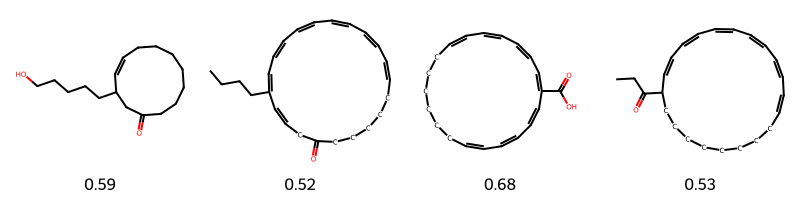

In [25]:
from rdkit import Chem
from rdkit.Chem import Draw
img=Draw.MolsToGridImage([x[0] for x  in final_mol_list],
                         molsPerRow=4,subImgSize=(200,200),
                         legends=[f"{x[1]:.2f}" for x in final_mol_list])
img

## SMILES로 유사분자 생성

In [27]:
np.array(['CC(=O)OC1=CC=CC=C1C(=O)O'])

array(['CC(=O)OC1=CC=CC=C1C(=O)O'], dtype='<U24')

In [28]:
print(model.predict_from_sequences(np.array(['CC(=O)OC1=CC=CC=C1C(=O)O'])))

[['C', '=', 'O', 'C', '=', '=', 'O', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C']]
